In [69]:
using DataFrames, CSV, Dates, Measures, Statistics, StatsPlots, IterativeSolvers, Polynomials, DelimitedFiles
include("./src/OptimizerParaibaDoSul.jl")
OPS = OptimizerParaibaDoSul

In [70]:
dir = "base_results"
df_reservoir = DataFrame(CSV.File(joinpath(dir,"results",dir*"_reservoir_Hm3.csv")))[:,["month","ps_equivalent_reservoir"]]

,month,ps_equivalent_reservoir
,Int64,Float64
1,1,0.946673
2,2,0.998262
3,3,1.0
4,4,1.0
5,5,1.0
6,6,1.0
7,7,0.968483
8,8,0.913217
9,9,0.874887


In [60]:
gdf = groupby(df_reservoir, "month")
df_stats = combine(gdf,
    "ps_equivalent_reservoir" => mean => "mean",
    "ps_equivalent_reservoir" => maximum => "max",
    "ps_equivalent_reservoir" => minimum => "min",
    "ps_equivalent_reservoir" => std => "std",
    )

,month,mean,max,min,std
,Int64,Float64,Float64,Float64,Float64
1,1,0.83585,1.0,0.158549,0.197732
2,2,0.879866,1.0,0.204769,0.189582
3,3,0.905726,1.0,0.248081,0.168852
4,4,0.896392,1.0,0.225346,0.171108
5,5,0.876286,1.0,0.176443,0.175476
6,6,0.839564,1.0,0.122449,0.177403
7,7,0.790173,1.0,0.0506449,0.182603
8,8,0.730763,1.0,-0.0151182,0.183928
9,9,0.686146,1.0,-0.0292304,0.187882


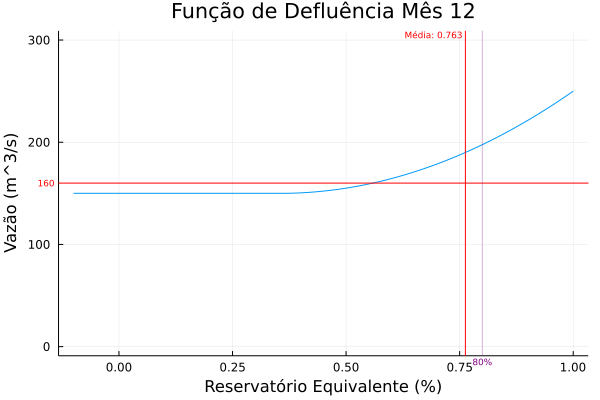

In [65]:
confidence = 2
b = [250,190,150]
coef = zeros(12,3)
for i in 1:size(df_stats,1)
    max = df_stats[i,"max"]
    min = df_stats[i,"mean"] - confidence*df_stats[i,"std"]
    avg = df_stats[i,"mean"]

    A = [max^2 max^1 max^0
        avg^2 avg^1 avg^0
        min^2 min^1 min^0]

    p = Polynomial(reverse(lsmr(A,b)))
    coef[i,:] = coeffs(p)
    d = derivative(p)
    x = -0.1:0.01:1
    y = [(p(i) > b[3]) && (d(i) > 0) ? p(i) : b[3] for i in x]
    p = plot(x,y,
        ylim = [0,300],
        legend = false,
        xlabel = "Reservatório Equivalente (%)",
        ylabel = "Vazão (m^3/s)",
        title = "Função de Defluência Mês $(i)"
    )

    p = plot!([avg], seriestype="vline",color=:red)
    annotate!(avg-0.07, 305, text("Média: "*string(round(avg,digits = 3)), :red, 6))

    p = plot!([160], seriestype="hline",color=:red)
    annotate!(-0.16, 160, text("160", :red, 6))

    p = plot!([0.8], seriestype="vline",color=:purple, alpha = 0.3)
    annotate!(0.8, -15, text("80%", :purple, 6))

    savefig("defluence_functions//month_$(i).png")
end
p

In [68]:
writedlm("start\\defluence_poly.csv",  coef, '\t')